# Import packages 

In [1]:
import numpy as np
import torch
from torch import nn, Tensor, no_grad
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd 
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.nn.utils.parametrize as parametrize
import math 
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from model import Model 
from data_util import sliding_windows, custom_data 

# Load data and preprocessing 

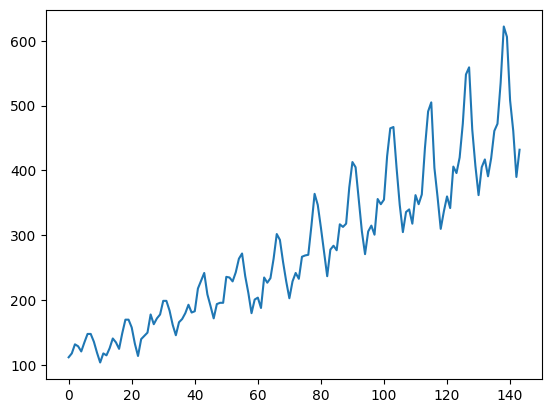

In [2]:
training_set = pd.read_csv('airplane.csv')
training_set = training_set.iloc[:,1:2].astype('float32')

plt.plot(training_set, label = 'Shampoo Sales Data')
plt.show()
     

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = (Variable(torch.from_numpy(np.array(x))))
dataY = (Variable(torch.from_numpy(np.array(y))))

trainX = (Variable(torch.from_numpy(np.array(x[0:train_size]))))
trainY = (Variable(torch.from_numpy(np.array(y[0:train_size]))))

testX = (Variable(torch.from_numpy(np.array(x[train_size:len(x)]))))
testY = (Variable(torch.from_numpy(np.array(y[train_size:len(y)]))))

load_train = custom_data(trainX, trainY)
load_test = custom_data(testX, testY)


# Train Model 

In [3]:
num_epochs = 1000
learning_rate = 0.001

input_size = 1
hidden_size = 10
num_layers = 1

out_size = 1
bsize = 64
mode = 'rnn'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Model(input_size, hidden_size, num_classes, nonlinearity, 
#               mode = mode).to(device)
layer_dim = trainX.shape[0]
model = Model(input_size, hidden_size, bsize , out_size, model='rnn')
model.float()
# model = Sequence(input_size, hidden_size,  num_classes )
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(model.parameters(), lr=1e-1)
# optimizer = optim.LBFGS(seq.parameters(), lr=0.1)
# Train the model

for epoch in range(num_epochs):
    model.train()
    loss_train = []
    for batch_x, batch_y in DataLoader(load_train, batch_size= bsize, shuffle = True):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
    
        loss.backward(retain_graph=True)
        loss_train.append(loss.item())
    
        optimizer.step()

    loss_val_l = []
    with no_grad():
        model.eval()
        
        for batch_x, batch_y in DataLoader(load_test, batch_size= bsize, shuffle= True):
            outputs = model(batch_x)
            loss_val = criterion(outputs, batch_y)
            loss_val_l.append(loss_val.item())

        
        
    if epoch % 100 == 0:
      print("Epoch: %d, loss train: %1.5f, loss test: %1.5f" % (epoch, np.mean(loss_train), np.mean(loss_val_l)))
     


Epoch: 0, loss train: 0.06674, loss test: 0.09892
Epoch: 100, loss train: 0.00172, loss test: 0.00715
Epoch: 200, loss train: 0.00186, loss test: 0.00860
Epoch: 300, loss train: 0.00174, loss test: 0.00733
Epoch: 400, loss train: 0.00183, loss test: 0.00697
Epoch: 500, loss train: 0.00174, loss test: 0.00852
Epoch: 600, loss train: 0.00165, loss test: 0.00748
Epoch: 700, loss train: 0.00176, loss test: 0.00803
Epoch: 800, loss train: 0.00192, loss test: 0.00732
Epoch: 900, loss train: 0.00170, loss test: 0.00739


# Visualization of results 

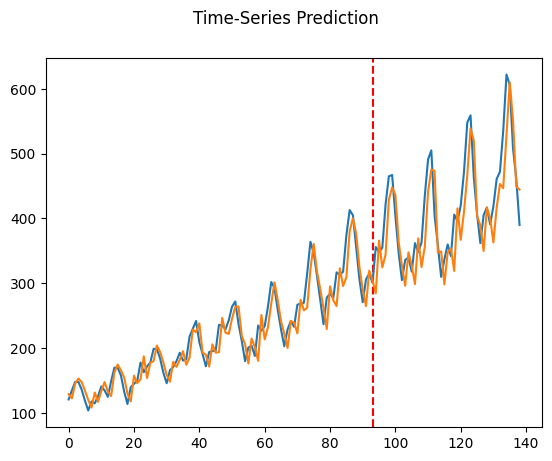

In [4]:
model.eval()
train_predict  = model(dataX)
     
# train_predict = model(dataX)

data_predict = train_predict[:,0].data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict.reshape(-1,1))
dataY_plot = sc.inverse_transform(dataY_plot.reshape(-1,1))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()